### First, import necessary packages:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import Calculation as cln

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


### Second, we generate the set of M2i(x) special functions
#### Here we take galaxy-clustering for example:

In [3]:
func_real_list, func_imag_list = cln.special_func_generator()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 5.0289400537808735 min


### Third, we could calculate the angular power spectrum

Note that, although Calculation.py has a default initial matter power spectrum implemented, here we show how can we choose another set of cosmology.

When we change the cosmology, we do not need to change the resulting func_real_list and func_imag_list

In [9]:
import Cosmology as Csm
import params as pa
#sampling_cosmo = Csm.Sampling(pa.c, pa.zCMB, pa.zmax, pa.h, pa.omch2, pa.ombh2, pa.ns, pa.s8)
defcos = Csm.MyCosmology()
sampling_cosmo = Csm.Sampling()
khmin = 1e-8
khmax = 52.0
Nmax = 200
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 0]
nu_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 1]

#### For equal time case: $z_1=z_2=1.0$, $\sigma_z = 0.05$:

In [5]:
our_l = np.array([2+i for i in range(98)]+[100+10*i for i in range(41)])

In [44]:
from scipy.integrate import simps
import time
def power_calc_sampling_mod(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_array, func_real_list, func_imag_list):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    xx = dchi_dchi *np.sqrt(l*(l+1))/chi_chi/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    l_tilde = np.sqrt(l*(l+1))/chi_chi/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    
    Cl_array_array = np.array([ (c_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    
    Cl_array = np.sum(Cl_array_array, axis=0)/(1-(dchi_dchi/2/chi_chi)**2)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2/(chi_chi)**2 * (dchi_dchi/chi_chi)**n

    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling_mod(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_array, func_real_list, func_imag_list):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = sampling_cosmo.mesh_grid_generator(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_mod(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_array, func_real_list, func_imag_list).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

In [20]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = sampling_cosmo.mesh_grid_generator(2.0, 3.5, 0.3, 0.3, 50, 50)
np.save('./Mesh_Planck18/Mesh_235',[chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2])

In [21]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2 = sampling_cosmo.mesh_grid_generator_CMBlensing(50, 50)
np.save('./Mesh_Planck18/Mesh_CMBlensing', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2])

(102, 50) (102, 50)


In [6]:
Cl_1_1_005 = cln.full_calc_sampling(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Time for preparing mesh-grids is: 10.061604976654053 s
Time for calculating each l is: 0.1351654032151476 s


#### Calculate our geometric modification:

In [7]:
Cl_1_1_005_mod = cln.full_calc_sampling_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Time for preparing mesh-grids is: 10.796817064285278 s
Time for calculating each l is: 0.12881710718003966 s


In [10]:
Cl_1_1_limber = np.array([cln.Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.0), 0.05/defcos.HH(1.0), 0.1, 7000) for li in our_l])

In [11]:
Cl_2_2 = cln.full_calc_sampling(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_2_2_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_2_2_limber = np.array([cln.Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(2.0), 0.3/defcos.HH(2.0), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 10.897186994552612 s
Time for calculating each l is: 0.13576457654829505 s
Time for preparing mesh-grids is: 11.497533321380615 s
Time for calculating each l is: 0.1423660559619931 s


In [12]:
Cl_1_125 = cln.full_calc_sampling(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_1_125_mod = cln.full_calc_sampling_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_1_125_limber = np.array([cln.Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.25), 0.05/defcos.HH(1.25), 0.1, 5000) for li in our_l])

Time for preparing mesh-grids is: 10.221100091934204 s
Time for calculating each l is: 0.11832609279550237 s
Time for preparing mesh-grids is: 9.495074987411499 s
Time for calculating each l is: 0.16104821507021677 s


#### For unequal time case: $z_1=2.0, z_2=3.5$, $\sigma_z = 0.3$:

In [13]:
Cl_2_35_03 = cln.full_calc_sampling(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_2_35_03_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_2_35_limber = np.array([cln.Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 12.691971063613892 s
Time for calculating each l is: 0.15527517332447519 s
Time for preparing mesh-grids is: 13.101638078689575 s
Time for calculating each l is: 0.1556794180286874 s


### Now, we demonstrate the CMB lensing case:

In [27]:
func_real_list_lensing, func_imag_list_lensing = cln.special_func_generator_CMBlensing()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 5.323144551118215 min


In [39]:
Cl_CMBlensing = cln.full_calc_sampling_CMBlensing(our_l, 100, 100, c_n_array, func_real_list_lensing, func_imag_list_lensing)
Cl_CMBlensing_mod = cln.full_calc_sampling_CMBlensing_mod(our_l, 100, 100, c_n_array, func_real_list_lensing, func_imag_list_lensing)

(202, 100) (202, 100)
Time for preparing mesh-grids is: 42.45140814781189 s
Time for calculating each l is: 0.5219358557419811 s
(202, 100) (202, 100)
Time for preparing mesh-grids is: 47.28937792778015 s
Time for calculating each l is: 0.5565133386378666 s


In [40]:
Cl_CMBlensing_limber = np.array([cln.Limber_CMBlensing(li, 0.1, sampling_cosmo.default_cosmo.chi(1090)) for li in our_l])

In [83]:
defcos = Csm.MyCosmology()

In [26]:
l_camb = np.array([0+i for i in range(501)])
Dlpp = defcos.results.get_lens_potential_cls(lmax = 500)

In [1]:
import camb
from camb import model, initialpower
import params as pa
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=pa.h*100, ombh2=pa.ombh2, omch2=pa.omch2, mnu=0.06, omk=0, tau=0.0561)
pars.InitPower.set_params(As=pa.As, ns=pa.ns, r=0)
pars.set_matter_power(redshifts=[0., 0.8], kmax=140)
pars.set_for_lmax(2500, lens_potential_accuracy=1)
pars.set_dark_energy(w=-1, wa=0, dark_energy_model='fluid')
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
print(results.get_sigma8())

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Note: redshifts have been re-sorted (earliest first)
[0.53982696 0.81027941]


In [27]:
l_camb = np.array([0+i for i in range(501)])
Dlpp = results.get_lens_potential_cls(lmax = 500)[:,0]

In [39]:
Dlpp[np.where(l_camb == 2)[0]]

array([4.99841667e-08])

In [42]:
Clpp = np.array([ Dlpp[np.where(l_camb == li)[0]][0] for li in our_l])*(2*np.pi)/(our_l*(our_l+1))**2

### Plotting:

### Note that all the full-sky calculation is directly generated from Assassi's Mathematica code, and the Limber approximation for galaxy-clustering is pre-calculated

In [52]:
from scipy.interpolate import interp1d
def plot_compare(Cl_full, Cl_limber, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, gridspec_kw={'height_ratios': [4, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', label=r'OurApprox')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', label=r'OurApprox Modified')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', label=r'Limber')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', label=r'FullSky')

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend(prop={'size':15})
    ax0.set_ylabel(r'$C_{\ell}^{\mathrm{g}}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=20)
    ax0.tick_params(labelsize=15)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r')
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b')
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g')
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
    ax1.set_xscale('log')
    ax1.set_ylim(-20, 20)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_xlabel(r'$\ell$',fontsize=20)
    ax1.set_ylabel(r'Ratio-1 [%]',fontsize=20)

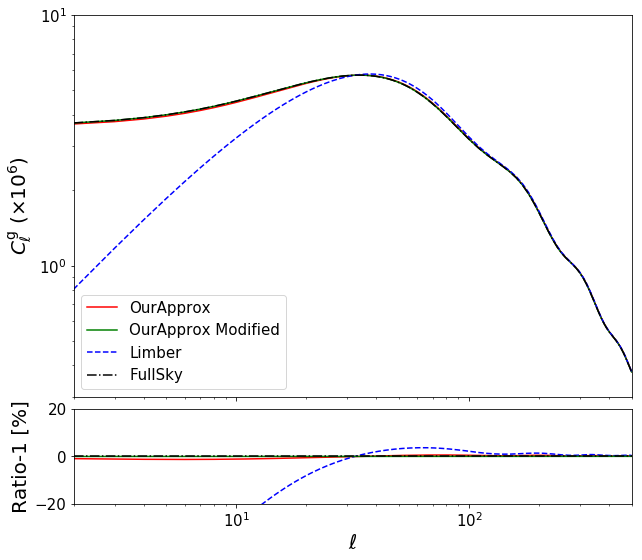

In [53]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
plot_compare(Cl11_full,\
    Cl_1_1_limber, np.array(our_l), Cl_1_1_005, Cl_1_1_005_mod, 0.3, 10, 2, 500, 1e6)

plt.savefig('./Figures/Cl_11.eps', dpi=100)

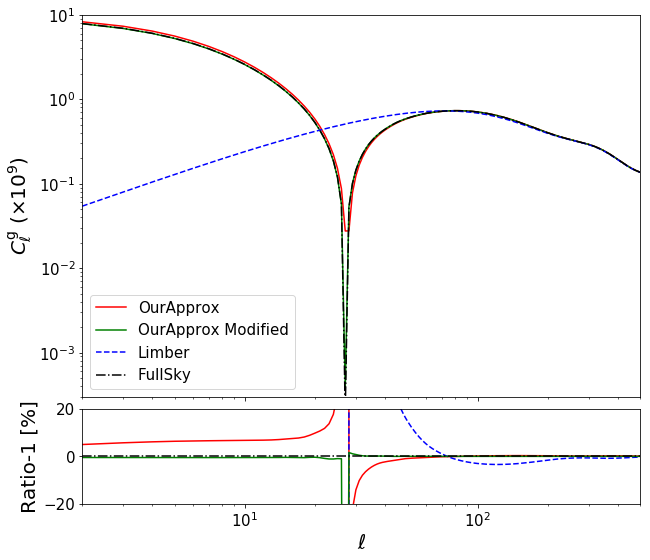

In [54]:
Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
plot_compare(Cl235_full,\
    Cl_2_35_limber, np.array(our_l), Cl_2_35_03, Cl_2_35_03_mod, 0.0003, 10, 2, 500, 1e9)
plt.savefig('./Figures/Cl_235.eps', dpi=100)

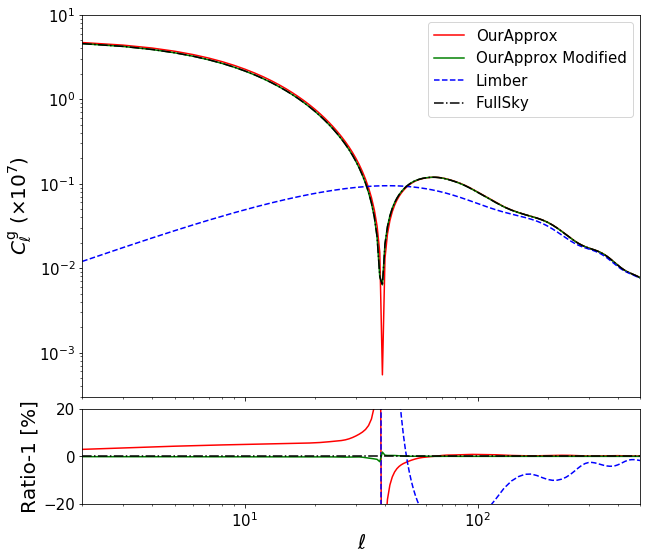

In [55]:
Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
plot_compare(Cl1125_full,\
    Cl_1_125_limber, np.array(our_l), Cl_1_125, Cl_1_125_mod, 0.0003, 10, 2, 500, 1e7)
plt.savefig('./Figures/Cl_1125.eps', dpi=100)

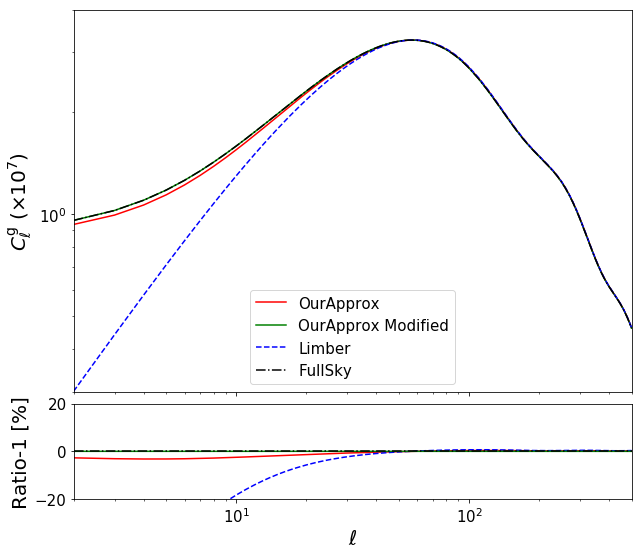

In [56]:
Cl22_full = np.loadtxt('./Full-sky/Cl_22_number.txt')[:,1]
plot_compare(Cl22_full,\
    Cl_2_2_limber, np.array(our_l), Cl_2_2, Cl_2_2_mod, 0.3, 4, 2, 500, 1e7)
plt.savefig('./Figures/Cl_22.eps', dpi=100)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

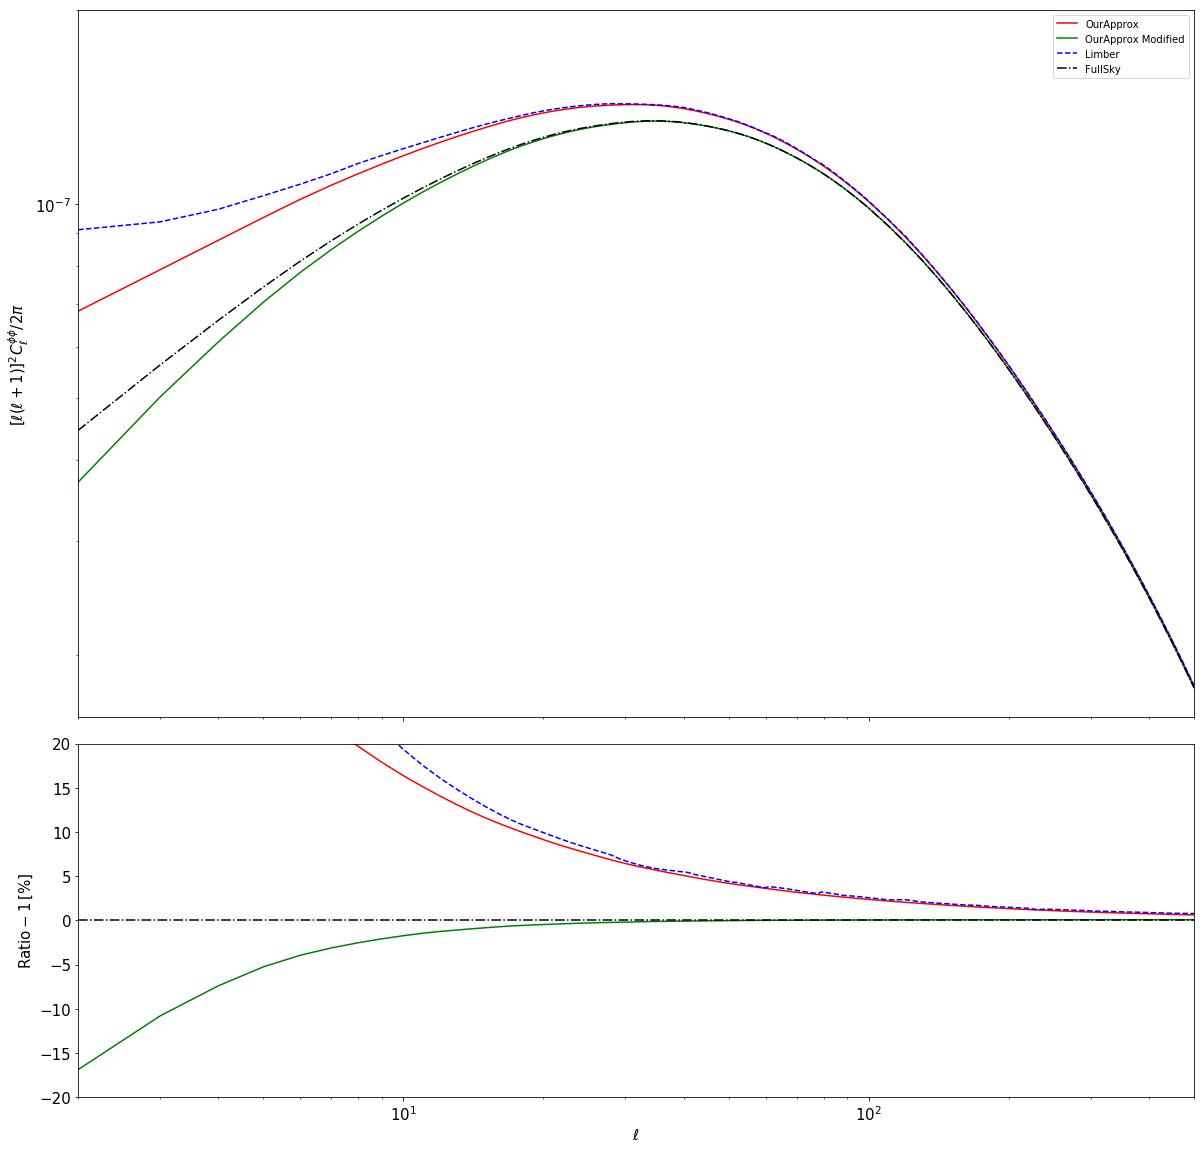

In [29]:
Cl_CMB_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,1]

fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi), color = 'r', label=r'OurApprox')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_mod/(2*np.pi), color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber/(2*np.pi), '--', color = 'b', label=r'Limber')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMB_full/(2*np.pi),'-.', color = 'k', label=r'FullSky')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend()
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.plot(our_l, (Cl_CMBlensing/Cl_CMB_full-1)*100, color='r')
ax1.plot(our_l, (Cl_CMBlensing_limber/Cl_CMB_full-1)*100,'--', color='b')
ax1.plot(our_l, (Cl_CMBlensing_mod/Cl_CMB_full-1)*100, color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

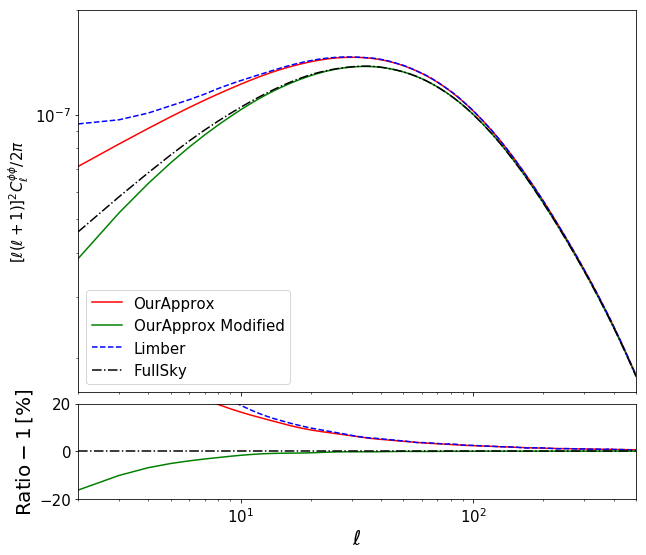

In [57]:
#l_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,0]
Cl_CMB_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,1]
fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, gridspec_kw={'height_ratios': [4, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]


ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi), color = 'r', label=r'OurApprox')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_mod/(2*np.pi), color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber/(2*np.pi), '--', color = 'b', label=r'Limber')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMB_full/(2*np.pi),'-.' ,color = 'k', label=r'FullSky')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
#ax0.plot(our_l, (our_l*(our_l+1))**2*Clpp/(2*np.pi),'-.', color = 'k', label=r'FullSky')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend(prop={'size':15})
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.plot(our_l, (Cl_CMBlensing/Cl_CMB_full-1)*100, color='r')
ax1.plot(our_l, (Cl_CMBlensing_limber/Cl_CMB_full-1)*100,'--', color='b')
ax1.plot(our_l, (Cl_CMBlensing_mod/Cl_CMB_full-1)*100, color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=20)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=20)
plt.savefig('./Figures/Cl_CMBlensing.eps', dpi=100)

In [65]:
from scipy.interpolate import interp1d
func_CMB = interp1d(np.log10(l_full), np.log10((l_full*(l_full+1))**2*Cl_CMB_full), 'cubic')
Cl_full = 10**func_CMB(np.log10(our_l))/(our_l*(our_l+1))**2


In [67]:
np.savetxt('./Full-sky/Cl_CMBlensing_number.txt', np.array([our_l, Cl_full]).T)